In [145]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from itertools import product
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [146]:
RANKS = [str(i) for i in range(2,10)] + ['T','J','Q','K','A']
SUITS = ['s','h','c','d']
DECK_DICT = {i:card for i, card in enumerate(product(RANKS,SUITS))}


In [147]:
class CardEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=2):
        super().__init__()
        self.embedder = nn.Embedding(52, embedding_dim)
        self.suit_classifier = nn.Linear(embedding_dim, 4)
        self.rank_classifier = nn.Linear(embedding_dim, 13)
        
    def forward(self, x):
        x_embed = self.embedder(x)
        suit_logits = self.suit_classifier(x_embed)
        rank_logits = self.rank_classifier(x_embed)
        return rank_logits, suit_logits

In [148]:
deck_data = [(i, *card) for i, card in enumerate(product(range(13),range(4)))]
cards = torch.tensor([c[0] for c in deck_data])
ranks = torch.tensor([c[1] for c in deck_data])
suits = torch.tensor([c[2] for c in deck_data])

In [149]:
model = CardEmbeddingModel(embedding_dim=4)
optimizer = torch.optim.SGD(params=model.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()

In [150]:
epochs = 2_000
rank_losses = []
suit_losses = []
losses = []
for epoch in range(epochs):
    rank_logit, suit_logit = model(cards)
    rank_loss = criterion(rank_logit, ranks)
    suit_loss = criterion(suit_logit, suits)
    tot_loss = rank_loss + suit_loss
    losses.append(tot_loss.item())
    rank_losses.append(rank_loss.item())
    suit_losses.append(suit_loss.item())
    tot_loss.backward()
    optimizer.step()
        

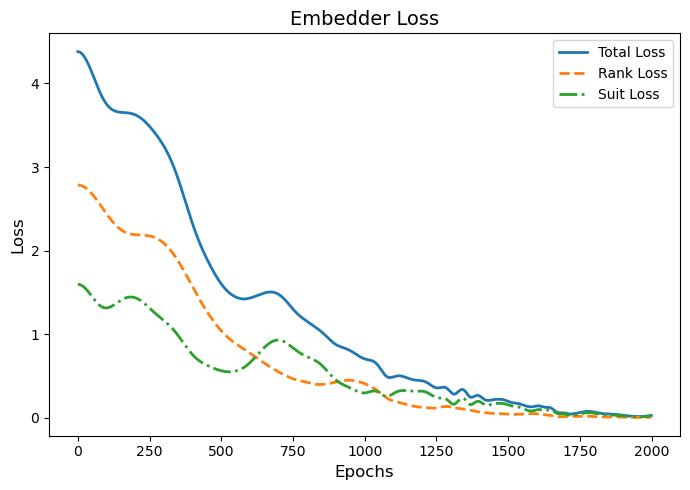

In [151]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=list(range(epochs)), y=losses, label="Total Loss", linestyle='-', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=rank_losses, label="Rank Loss", linestyle='--', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=suit_losses, label="Suit Loss", linestyle='-.', linewidth=2)

plt.title("Embedder Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()

In [152]:
def compute_accuracy(model, card_indices, ranks, suits):
    with torch.no_grad():
        rank_logits, suit_logits = model(card_indices)
        rank_preds = torch.argmax(rank_logits, dim=1) 
        suit_preds = torch.argmax(suit_logits, dim=1)

        rank_acc = (rank_preds == ranks).float().mean().item()
        suit_acc = (suit_preds == suits).float().mean().item()
    return rank_acc, suit_acc

In [153]:
rank_acc, suit_acc = compute_accuracy(model, cards, ranks, suits)
print('Rank Accuracy: ', rank_acc)
print('Suit Accuracy: ', suit_acc)

Rank Accuracy:  1.0
Suit Accuracy:  1.0


In [154]:
with torch.no_grad():
    learned_embeddings = model.embedder.weight
    print("Learned Card Embeddings:", learned_embeddings)

Learned Card Embeddings: Parameter containing:
tensor([[ -2.0453,  -0.5119,   0.7372,  -0.3220],
        [-10.3543,  -9.7442,   3.2772,  -0.5585],
        [ -6.5011,   4.8682,   7.3576,   9.2149],
        [ -2.8727,   1.2958,  -0.5001,   2.3813],
        [ -0.6419,  -1.8399,  -1.8537,   0.4889],
        [ -6.1627,  -8.7444, -11.4338,   6.0880],
        [  0.6519,   2.8985,  -6.6749,   7.7191],
        [ -1.0539,  -0.2118,  -1.9750,   1.3034],
        [  8.0437, -10.5018,  10.8696, -12.8877],
        [-11.7701, -11.8093,  10.9416,  -6.7322],
        [ 10.1741,   5.5887,   5.1488,   4.2099],
        [  7.2860,  -0.4425,   2.9378,   1.0469],
        [ -6.4084,   7.0659,   0.4095,  -5.3367],
        [ -7.9163,   5.1341,  -0.7645,  -8.0846],
        [ -2.1037,  12.5317,  -0.3805,   1.0145],
        [ -5.1687,  11.7327,  -4.3110,  -7.4662],
        [  4.6984, -17.3912,   8.4423,  -3.6336],
        [ -4.3002, -15.1711,  -0.1431,   4.8986],
        [  9.4387,  -6.0338,   5.5682,  13.9854],
   

In [160]:
pca = PCA(n_components=3)
z_pca = pca.fit_transform(learned_embeddings.detach().numpy())

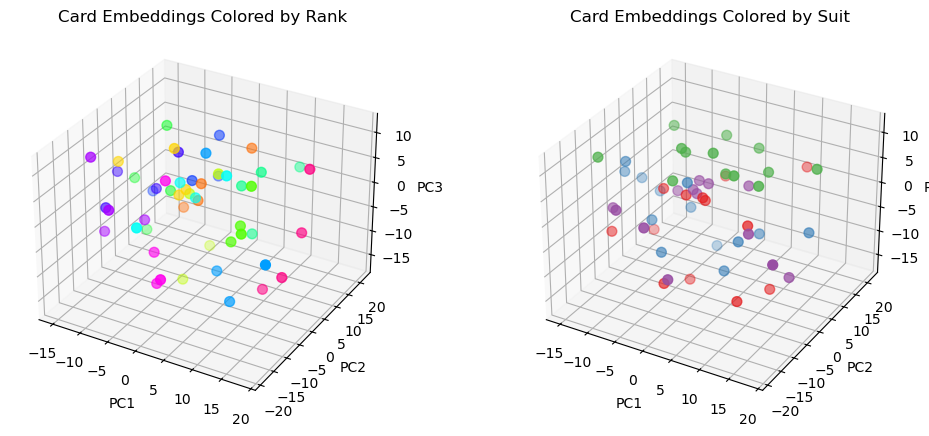

In [ ]:
rank_palette = sns.color_palette("hsv", 13)
suit_palette = sns.color_palette("Set1", 4)
rank_colors = [rank_palette[r] for r in ranks]
suit_colors = [suit_palette[s] for s in suits]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=rank_colors, s=50)
ax1.set_title("Card Embeddings Colored by Rank")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=suit_colors, s=50)
ax2.set_title("Card Embeddings Colored by Suit")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.show()

In [162]:
tsne = TSNE(n_components=3)
z_tsne = tsne.fit_transform(learned_embeddings.detach().numpy())

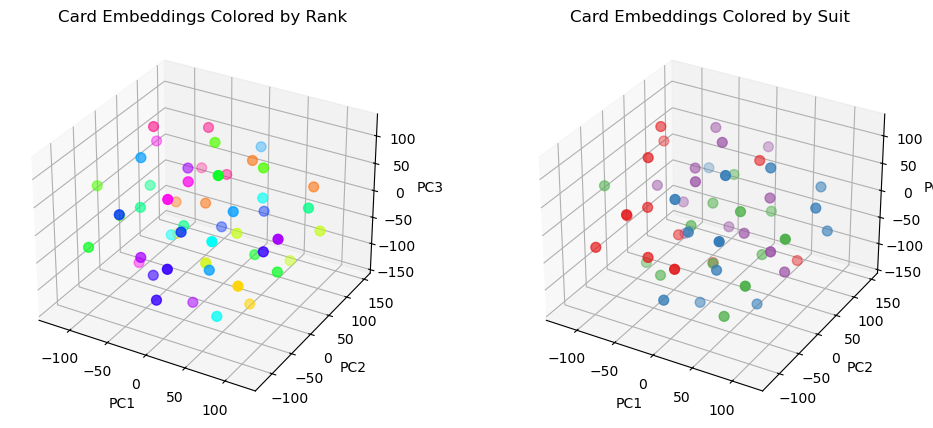

In [163]:
rank_palette = sns.color_palette("hsv", 13)
suit_palette = sns.color_palette("Set1", 4)
rank_colors = [rank_palette[r] for r in ranks]
suit_colors = [suit_palette[s] for s in suits]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], c=rank_colors, s=50)
ax1.set_title("Card Embeddings Colored by Rank")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")


ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], c=suit_colors, s=50)
ax2.set_title("Card Embeddings Colored by Suit")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.show()